In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import logging
import seaborn as sns
import numpy as np
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## Studying weather data in Adrar
With this notebook we aim to compare the weather data in our dataset (M2T1NXRAD) with the one used in [1]. To do so, we reproduce the weather-related figures in the paper for the same year - 1995 - and coordinates. 

[1] B. Bouzidi, “New sizing method of PV water pumping systems,” Sustainable Energy Technologies and Assessments, vol. 4, pp. 1–10, Dec. 2013, doi: 10.1016/j.seta.2013.08.004.


In [4]:
DATASETS = {
    "SWGDN_1995": "/media/ismail/BIG/datasets/M2T1NXRAD_5-1995_only_SWGDN.nc4", # Surface incoming shortwave flux, same as the one used in Carlsson and Redner, 2023
    "T2M_1995": "/media/ismail/BIG/datasets/M2T1NXSLV_5-1995_only_T2M.nc4", # 2m air temperature
}

radiation_data_file = DATASETS["SWGDN_1995"]
logging.info(f"Opening dataset: {radiation_data_file}")
radation_ds = xr.open_dataset(radiation_data_file)["SWGDN"]

temp_data_file = DATASETS["T2M_1995"]
logging.info(f"Opening dataset: {temp_data_file}")
temp_ds = xr.open_dataset(temp_data_file)["T2M"] - 273.15 # Convert to Celsius

2024-11-20 12:35:44,597 - INFO - Opening dataset: /media/ismail/BIG/datasets/M2T1NXRAD_5-1995_only_SWGDN.nc4
2024-11-20 12:35:44,664 - INFO - Opening dataset: /media/ismail/BIG/datasets/M2T1NXSLV_5-1995_only_T2M.nc4


2024-11-20 12:43:34,440 - INFO - Latitude: 27.8667, Longitude: -0.2833
2024-11-20 12:43:34,458 - INFO - Distance to nearest radiation point: 31.532280724598614 km
2024-11-20 12:43:34,459 - INFO - Distance to nearest temperature point: 31.532280724598614 km


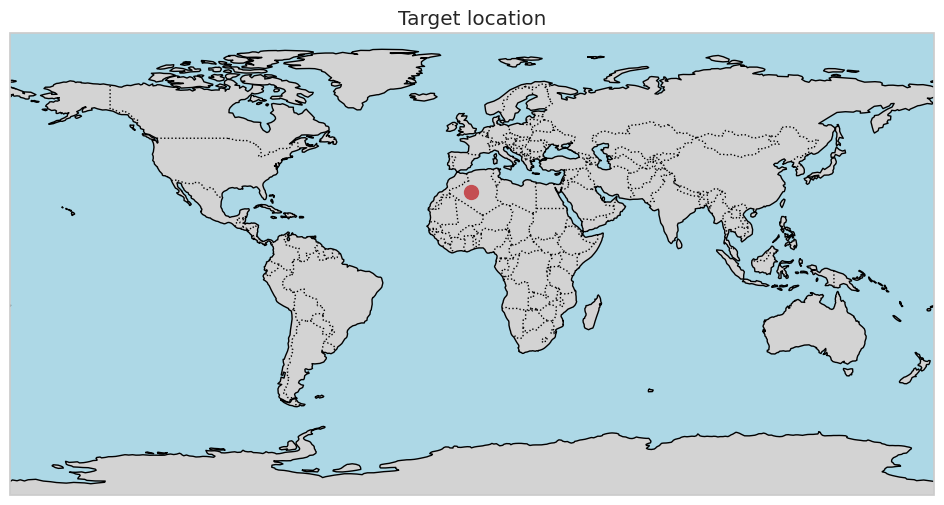

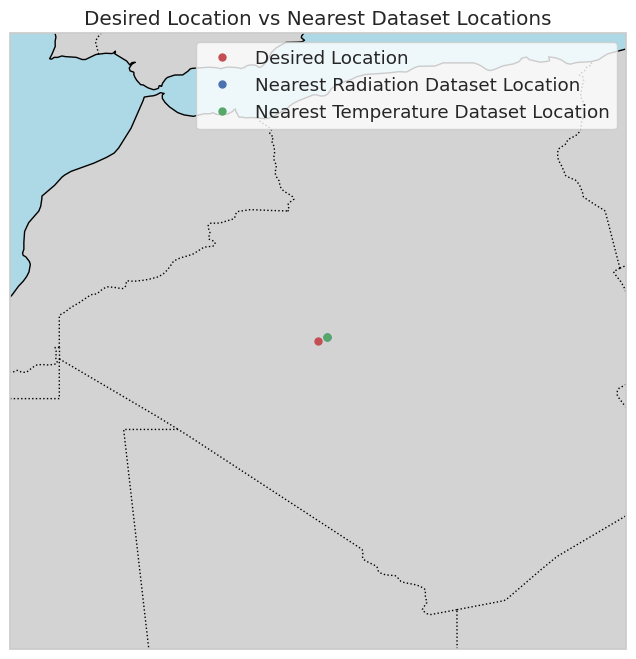

In [17]:
# Target location
latitude = 27.8667
longitude = -0.2833 

logging.info(f"Latitude: {latitude}, Longitude: {longitude}")

# Plot target location on a world map map
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.plot(longitude, latitude, 'ro', transform=ccrs.PlateCarree(), markersize=10)
plt.title("Target location")

# Nearest locations in the datasets
location_radiation_ds = radation_ds.sel(lat=latitude, lon=longitude, method="nearest")
nearest_lat_rad = location_radiation_ds.lat.values
nearest_lon_rad = location_radiation_ds.lon.values

location_temp_ds = temp_ds.sel(lat=latitude, lon=longitude, method="nearest")
nearest_lat_temp = location_temp_ds.lat.values
nearest_lon_temp = location_temp_ds.lon.values

dist_rad = 6371 * 2 * np.arcsin(np.sqrt(
    np.sin((np.radians(nearest_lat_rad - latitude)) / 2)**2 + 
    np.cos(np.radians(latitude)) * np.cos(np.radians(nearest_lat_rad)) * 
    np.sin((np.radians(nearest_lon_rad - longitude)) / 2)**2
))

dist_temp = 6371 * 2 * np.arcsin(np.sqrt(
    np.sin((np.radians(nearest_lat_temp - latitude)) / 2)**2 + 
    np.cos(np.radians(latitude)) * np.cos(np.radians(nearest_lat_temp)) * 
    np.sin((np.radians(nearest_lon_temp - longitude)) / 2)**2
))

logging.info(f"Distance to nearest radiation point: {dist_rad} km")
logging.info(f"Distance to nearest temperature point: {dist_temp} km")

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.plot(longitude, latitude, 'ro', label='Desired Location', transform=ccrs.PlateCarree(), markersize=5)
ax.plot(nearest_lon_rad, nearest_lat_rad, 'bo', label='Nearest Radiation Dataset Location', transform=ccrs.PlateCarree(), markersize=5)
ax.plot(nearest_lon_temp, nearest_lat_temp, 'go', label='Nearest Temperature Dataset Location', transform=ccrs.PlateCarree(), markersize=5)
margin = 10
ax.set_extent([longitude - margin, longitude + margin, latitude - margin, latitude + margin], crs=ccrs.PlateCarree())

plt.title("Desired Location vs Nearest Dataset Locations")
plt.legend()
plt.show()



### Reproducing Figure 2: 
Average daily monthly irradiation and temperature of Adrar.


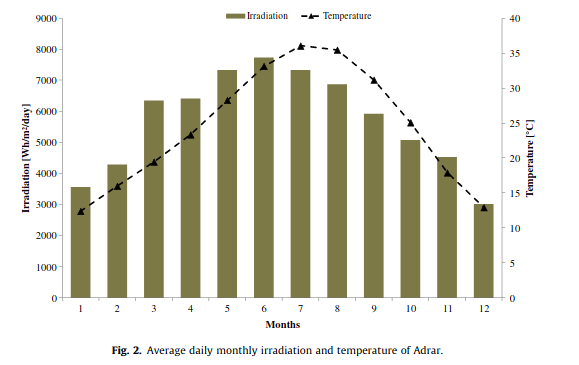

2024-11-20 12:53:49,800 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-20 12:53:49,803 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


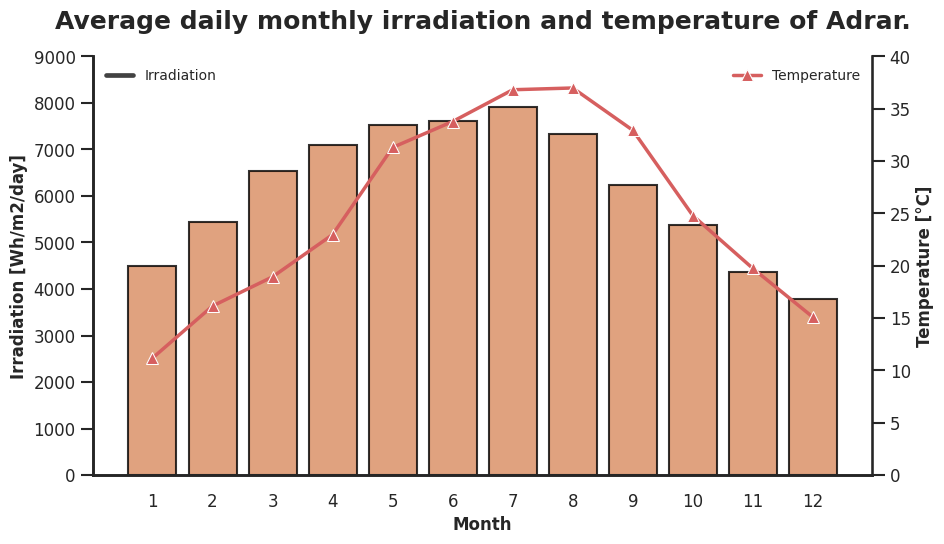

In [21]:
daily_radiation = location_radiation_ds.sel(time="1995").resample(time="1D").sum()
monthly_avg_irradiation = daily_radiation.resample(time="1ME").mean()
daily_temperature = location_temp_ds.sel(time="1995").resample(time="1D").mean()
monthly_avg_temperature = daily_temperature.resample(time="1ME").mean()

months = range(1, 13) 
irradiation_values = monthly_avg_irradiation.values
temperature_values = monthly_avg_temperature.values

sns.set_theme(style="white", context="talk", font_scale=1.4)

colors = sns.color_palette("muted")
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(
    x=list(months),
    y=irradiation_values,
    color=colors[1],  
    edgecolor="black",
    alpha=0.8,
    ax=ax1,
)
ax1.set_xlabel("Month", fontsize=12, weight="bold")
ax1.set_ylabel("Irradiation [Wh/m2/day]", fontsize=12, weight="bold")
ax1.tick_params(axis="y", labelsize=12, direction="out", width=1.5)
ax1.tick_params(axis="x", labelsize=12, direction="out", width=1.5)
ax1.set_ylim(0, 9000)
ax1.set_xticks(range(12))
ax1.set_xticklabels(range(1, 13))
ax1.legend(["Irradiation"], loc="upper left", fontsize=10, frameon=False)

ax2 = ax1.twinx()
sns.lineplot(
    x=range(12), # don't know why it's not working with list(months)
    y=temperature_values,
    color=colors[3],  
    marker="^",
    dashes=True,
    linewidth=2.5,
    markersize=8,
    ax=ax2,
)
ax2.set_ylabel("Temperature [°C]", fontsize=12, weight="bold")
ax2.tick_params(axis="y", labelsize=12, direction="out", width=1.5)
ax2.set_ylim(0, 40)
ax2.legend(["Temperature"], loc="upper right", fontsize=10, frameon=False)

plt.title(
    "Average daily monthly irradiation and temperature of Adrar.",
    fontsize=18,
    pad=20,
    weight="bold",
)

sns.despine(ax=ax1, top=True, right=True)
sns.despine(ax=ax2, top=True, right=False)

plt.tight_layout()
plt.show()
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)

### Reproducing figure 4
Hourly global irradiation on the horizontal and array PV plane (angle of inclination equal to the latitude of the site) – January – Adrar.

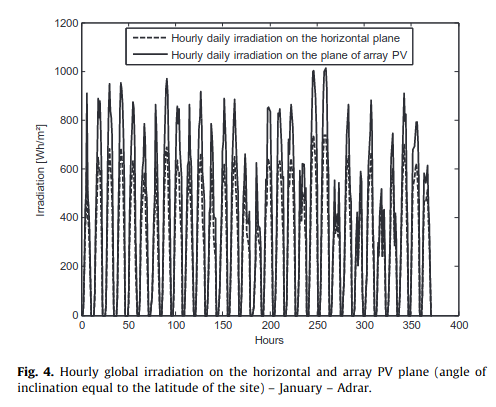

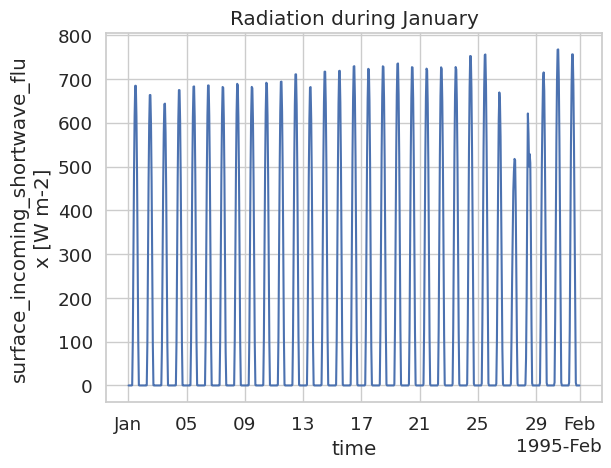

In [20]:
location_radiation_ds.sel(time="1995-01").plot()
plt.title("Radiation during January")
plt.show()